# Modulation Recognition with Deep Learning
# This notebook is for the Fully Connected NN

We try fully connected feed forward neural networks as a baseline to classify 11 different modulation schemes. We compare the performance of the more sophisticated convolutional neural networks against the baseline.

## Downloading the data set

In [ ]:
!kill -9 -1

In [1]:
!curl http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2 --output dataset.pkl.bz2
!bzip2 -d dataset.pkl.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  106M  100  106M    0     0   106M      0  0:00:01  0:00:01 --:--:-- 63.6M


In [ ]:
!rm -rf dataset.pkl.bz2 # release some memory from colab

In [ ]:
#@title Downloading the data
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

## Python imports

In [ ]:
import tensorflow
import keras
import pickle
import h5py
import numpy as np
import pydot
# import graphviz


# h5py.run_tests()
from keras.models import Sequential
from keras.utils import np_utils, plot_model
from keras.wrappers.scikit_learn import KerasClassifier
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import seaborn as sns
import random, sys
from scipy.interpolate import UnivariateSpline

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## Importing the dataset

In [ ]:
# The dataset is a pickle file of a serialized python dictionary object where
# its keys are a 2-tuples of (modulation scheme name, SNR)
# SNR ranges from -20 to 20 dB with step size of 2

# set encoding because of incompatibility issue between python 2 and python 3
dataset = pickle._Unpickler(open("dataset.pkl","rb"), encoding='latin1').load()

# delete the file after loading it into memory
!rm -f dataset.pkl

In [6]:
# show memory usage
!cat /proc/meminfo

MemTotal:       13341832 kB
MemFree:          632228 kB
MemAvailable:   12110236 kB
Buffers:          138080 kB
Cached:         11246372 kB
SwapCached:            0 kB
Active:          3371800 kB
Inactive:        8624824 kB
Active(anon):     782720 kB
Inactive(anon):    83448 kB
Active(file):    2589080 kB
Inactive(file):  8541376 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1924 kB
Writeback:             0 kB
AnonPages:        612260 kB
Mapped:           195612 kB
Shmem:            253924 kB
Slab:             627488 kB
SReclaimable:     600968 kB
SUnreclaim:        26520 kB
KernelStack:        3232 kB
PageTables:         6084 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6670916 kB
Committed_AS:    1959740 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
HugePages_Total: 

In [7]:
print(dataset[('BPSK', 10)].shape)

(1247, 2, 128)


In [8]:
modulations = set()

for key in dataset:
    modulations.add(key[0])

modulations_dict = dict([(name, num) for num, name in enumerate(modulations)])
print(modulations_dict)
snrs = np.linspace(-20, 18, 20, dtype=int) 
print(snrs)
mods = modulations

{'GFSK': 0, '8PSK': 1, 'AM-DSB': 2, 'QPSK': 3, 'QAM64': 4, 'BPSK': 5, 'AM-SSB': 6, 'QAM16': 7, 'PAM4': 8, 'CPFSK': 9, 'WBFM': 10}
[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18]


In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [10]:
def get_data_matrix(dataset, train_test_split=0.5, normalize=False, diff=False, integration=False):
#  split the data in the shape of (rows,2,128)
# get numbers of rows
    rows = 0
    for key in dataset:
        rows += dataset[key].shape[0]

    X = np.empty([rows, dataset[key].shape[1], dataset[key].shape[2]])
    y = []
    lbl = []
    idx = 0
    for key in dataset:
        for item in dataset[key]:
            tmp = np.array(item).reshape((dataset[key].shape[1], dataset[key].shape[2]))
            X[idx] = tmp
            y.append(modulations_dict[key[0]])
            lbl.append(key)
            idx += 1
    if normalize or diff or integration :
      num_row_per_feature = dataset[key].shape[1]
      
      if integration:
        num_row_per_feature +=2
      if diff:
        num_row_per_feature +=2
      
      X_opp=np.empty([rows, num_row_per_feature, dataset[key].shape[2]])
      
      for idx in range(rows):
        tmp_normalize = np.empty([dataset[key].shape[1], dataset[key].shape[2]])
        tmp_diff = np.empty([dataset[key].shape[1], dataset[key].shape[2]])
        tmp_integration = np.empty([dataset[key].shape[1], dataset[key].shape[2]])
        if normalize:
          X_mean = X[idx].mean().astype(np.float32)
          X_sdev = X[idx].std().astype(np.float32)
          tmp_normalize = (X[idx] - X_mean)/X_sdev
        else :
          tmp_normalize = X[idx]
        if diff :
          tmp_diff = np.gradient(X[idx], axis=1)
        if integration :
          for idx1 in range(X[idx].shape[0]):
            currentVec=X[idx,idx1,::].reshape((1,X.shape[2]))
            anti_der = UnivariateSpline(np.linspace(0,1,128),currentVec).antiderivative()                            
            anti_der = np.array([anti_der(i) for i in np.linspace(0,1,128)]).reshape(1,128)
            tmp_integration[idx1] = anti_der
       
        if diff and integration:  
          X_opp[idx] = np.concatenate((tmp_normalize,tmp_diff,tmp_integration), axis=0)
        elif diff :  
          X_opp[idx] = np.concatenate((tmp_normalize,tmp_diff), axis=0)
        elif integration :  
          X_opp[idx] = np.concatenate((tmp_normalize,tmp_integration), axis=0)
        else:  
          X_opp[idx] = np.concatenate((tmp_normalize), axis=0)
         
        if idx % 5000 == 0:
            print(idx)
        idx += 1          
        
#     make one hot to represent y
    y = np.array(to_onehot(y), dtype=int)
    lbl = np.array(lbl)
    if diff or integration:
      X = X_opp
    # Partition the data
    np.random.seed(2016)
    n_examples = X.shape[0]
    n_train = int(n_examples * train_test_split)

    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx))

    X_train = X[train_idx]
    X_test =  X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    lbl_train = lbl[train_idx]
    lbl_test = lbl[test_idx]
    return X_train, y_train, lbl_train, X_test, y_test, lbl_test
  
# features are in this order if all present row data , diff data, intg data
X_train, y_train, lbl_train, X_test, y_test, lbl_test = get_data_matrix(dataset,normalize=True, integration= True, diff = True)            

0
5000


/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
A theoretically impossible result was found during the iteration
proces for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000


In [ ]:
def cross_validate(total_size, val_set_size):
    n_examples = total_size
    n_data = int(n_examples * (1-val_set_size))
    data_idx = np.random.choice(range(0,n_examples), size=n_data, replace=False)
    val_idx = list(set(range(0,n_examples))-set(data_idx))
    return [(np.array(data_idx), np.array(val_idx))]
    

## Fully Connected Network

In [ ]:
# used by sklearn to grid search the hyper parameters
def build_model(layers_sizes=[256], dropout=0.5, hidden_activation='relu', output_activation='softmax',
                input_shape = [2,128], kernel_initializer='he_normal', optimizer='adam',
               loss='categorical_crossentropy', metrics=['accuracy']):
    model = Sequential()
    
    # add input layer (need to specify input shape)
    model.add(Dense(layers_sizes[0], activation=hidden_activation, input_shape=input_shape,
                    kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    
    # add remaining layers (if any)
    for layer in layers_sizes[1::]:
        model.add(Dense(layer,activation=hidden_activation, input_shape=input_shape,
                    kernel_initializer=kernel_initializer))
        model.add(Dropout(dropout))
    
    # add output layer
    model.add(Flatten())
    model.add(Dense(11, name='output', activation=output_activation, kernel_initializer=kernel_initializer))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


In [ ]:
#  early stop callback

class EarlyStoppingByLossVal(keras.callbacks.Callback):
    def __init__(self, monitor='loss', value=0.01, verbose=0):
        super(keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
callbacks = [
    EarlyStoppingByLossVal(monitor='loss', value=0.00001, verbose=1),
]

In [ ]:
# create the hyper parameters space
layers_sizes = [[256,128]]
input_shape = [[int(X_test.shape[1]), int(X_test.shape[2])]]
hidden_activation = ['relu']
dropout = [0.4]
param_grid = dict(layers_sizes=layers_sizes, hidden_activation=hidden_activation, dropout=dropout, input_shape = input_shape)
small_param_grid = dict(layers_sizes=[[256,128]], dropout=[0.5], batch_size=[256])

model = KerasClassifier(build_fn=build_model, epochs=20, validation_split=0.05)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1, refit=False)
grid_result = grid.fit(X_train[:,:,:], y_train, callbacks= callbacks)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:
def operation_comp(X_train, y_train, callbacks, params):
  best_params_list = []
  for itr in params:
    layers_sizes = [[256,128]]
    input_shape = [[X_train[:,itr[0]:itr[1],:].shape[1], X_test.shape[2]]]
    hidden_activation = ['relu']
    dropout = [0.4]
    param_grid = dict(layers_sizes=layers_sizes, hidden_activation=hidden_activation, dropout=dropout, input_shape = input_shape)
    model = KerasClassifier(build_fn=build_model, epochs=20, validation_split=0.05)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1, refit=False)
    grid_result = grid.fit(X_train[:,itr[0]:itr[1],:], y_train, callbacks= callbacks)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    best_params_list.append(grid_result.best_params_)
  return best_params_list

In [ ]:
def best_param_models (test):
  models =[]
  for param in test:
    best_params = param
    best_params['metrics'] = ['categorical_accuracy']
    model = build_model(**best_params)
    # model = build_model(**grid.best_params_)
    SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
    models.append(model)
  return models

## Setting the params with the number of featurres you want

In [30]:
params =[[0,2], [2,4], [4,6], [0,4], [2,6], [0,6]] 
best_params_list = operation_comp(X_train, y_train, callbacks, params)
models = best_param_models (best_params_list)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Train on 38489 samples, validate on 2026 samples
Epoch 1/10
38489/38489 [==============================] - 9s 238us/step - loss: 2.0170 - acc: 0.2708 - val_loss: 1.7534 - val_acc: 0.3578
Epoch 2/10
38489/38489 [==============================] - 9s 227us/step - loss: 1.7590 - acc: 0.3480 - val_loss: 1.6461 - val_acc: 0.3904
Epoch 3/10
 5376/38489 [===>..........................] - ETA: 7s - loss: 1.6811 - acc: 0.375738489/38489 [==============================] - 9s 224us/step - loss: 1.6760 - acc: 0.3747 - val_loss: 1.5952 - val_acc: 0.3914
Epoch 4/10
38489/38489 [==============================] - 9s 223us/step - loss: 1.6230 - acc: 0.3934 - val_loss: 1.5556 - val_acc: 0.4038
Epoch 5/10
36352/38489 [===========================>..] - ETA: 0s - loss: 1.5946 - acc: 0.402138489/38489 [==============================] - 9s 222us/step - loss: 1.5958 - acc: 0.4015 - val_loss: 1.5371 - val_acc: 0.4102
Epoch 6/10
38489/38489 [============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished


Train on 38489 samples, validate on 2026 samples
Epoch 1/10
38489/38489 [==============================] - 9s 235us/step - loss: 3.3601 - acc: 0.1584 - val_loss: 2.2464 - val_acc: 0.1885
Epoch 2/10
38489/38489 [==============================] - 9s 229us/step - loss: 2.2100 - acc: 0.1877 - val_loss: 2.1560 - val_acc: 0.1979
Epoch 3/10
17504/38489 [============>.................] - ETA: 4s - loss: 2.1662 - acc: 0.198338489/38489 [==============================] - 9s 227us/step - loss: 2.1479 - acc: 0.2153 - val_loss: 2.0906 - val_acc: 0.2581
Epoch 4/10
38489/38489 [==============================] - 9s 225us/step - loss: 2.0746 - acc: 0.2480 - val_loss: 1.9889 - val_acc: 0.2804
Epoch 5/10
38489/38489 [==============================] - 8s 217us/step - loss: 2.0049 - acc: 0.2631 - val_loss: 1.8839 - val_acc: 0.3050
Epoch 6/10
  480/38489 [..............................] - ETA: 9s - loss: 1.9715 - acc: 0.260438489/38489 [==============================] - 8s 217us/step - loss: 1.8818 - acc: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished


Train on 38489 samples, validate on 2026 samples
Epoch 1/10
38489/38489 [==============================] - 9s 235us/step - loss: 2.3533 - acc: 0.2248 - val_loss: 2.0092 - val_acc: 0.3119
Epoch 2/10
38489/38489 [==============================] - 8s 220us/step - loss: 1.9756 - acc: 0.3105 - val_loss: 1.8402 - val_acc: 0.3554
Epoch 3/10
19136/38489 [=============>................] - ETA: 4s - loss: 1.8645 - acc: 0.339838489/38489 [==============================] - 8s 221us/step - loss: 1.8404 - acc: 0.3432 - val_loss: 1.7216 - val_acc: 0.3731
Epoch 4/10
38489/38489 [==============================] - 8s 219us/step - loss: 1.7748 - acc: 0.3589 - val_loss: 1.6850 - val_acc: 0.3845
Epoch 5/10
38489/38489 [==============================] - 9s 222us/step - loss: 1.7539 - acc: 0.3622 - val_loss: 1.6486 - val_acc: 0.3944
Epoch 6/10
  736/38489 [..............................] - ETA: 8s - loss: 1.6573 - acc: 0.404938489/38489 [==============================] - 9s 227us/step - loss: 1.7329 - acc: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished


Train on 38489 samples, validate on 2026 samples
Epoch 1/10
38489/38489 [==============================] - 9s 236us/step - loss: 2.8865 - acc: 0.2073 - val_loss: 2.0121 - val_acc: 0.2710
Epoch 2/10
38489/38489 [==============================] - 9s 228us/step - loss: 1.9696 - acc: 0.2793 - val_loss: 1.7821 - val_acc: 0.3608
Epoch 3/10
17696/38489 [============>.................] - ETA: 4s - loss: 1.8299 - acc: 0.328738489/38489 [==============================] - 9s 231us/step - loss: 1.7830 - acc: 0.3419 - val_loss: 1.5692 - val_acc: 0.4166
Epoch 4/10
38489/38489 [==============================] - 9s 227us/step - loss: 1.5982 - acc: 0.4033 - val_loss: 1.4312 - val_acc: 0.4748
Epoch 5/10
37088/38489 [===========================>..] - ETA: 0s - loss: 1.4970 - acc: 0.438438489/38489 [==============================] - 9s 230us/step - loss: 1.4969 - acc: 0.4380 - val_loss: 1.3496 - val_acc: 0.4936
Epoch 6/10
38489/38489 [==============================] - 9s 226us/step - loss: 1.4434 - acc: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished


Train on 38489 samples, validate on 2026 samples
Epoch 1/10
38489/38489 [==============================] - 10s 250us/step - loss: 3.0553 - acc: 0.2221 - val_loss: 2.0026 - val_acc: 0.3203
Epoch 2/10
38489/38489 [==============================] - 9s 230us/step - loss: 1.9386 - acc: 0.3059 - val_loss: 1.7623 - val_acc: 0.3643
Epoch 3/10
16192/38489 [===========>..................] - ETA: 4s - loss: 1.8342 - acc: 0.335838489/38489 [==============================] - 9s 228us/step - loss: 1.8085 - acc: 0.3434 - val_loss: 1.6624 - val_acc: 0.3771
Epoch 4/10
38489/38489 [==============================] - 9s 227us/step - loss: 1.7508 - acc: 0.3566 - val_loss: 1.6383 - val_acc: 0.3939
Epoch 5/10
37216/38489 [============================>.] - ETA: 0s - loss: 1.6818 - acc: 0.380538489/38489 [==============================] - 9s 227us/step - loss: 1.6825 - acc: 0.3813 - val_loss: 1.5335 - val_acc: 0.4215
Epoch 6/10
38489/38489 [==============================] - 9s 225us/step - loss: 1.5984 - acc: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished


Train on 38489 samples, validate on 2026 samples
Epoch 1/10
38489/38489 [==============================] - 9s 246us/step - loss: 2.8481 - acc: 0.2469 - val_loss: 1.9252 - val_acc: 0.3124
Epoch 2/10
38489/38489 [==============================] - 9s 229us/step - loss: 1.8783 - acc: 0.3275 - val_loss: 1.6577 - val_acc: 0.3885
Epoch 3/10
16640/38489 [===========>..................] - ETA: 4s - loss: 1.7256 - acc: 0.371338489/38489 [==============================] - 9s 231us/step - loss: 1.6814 - acc: 0.3842 - val_loss: 1.4802 - val_acc: 0.4664
Epoch 4/10
38489/38489 [==============================] - 9s 231us/step - loss: 1.5255 - acc: 0.4360 - val_loss: 1.3610 - val_acc: 0.4901
Epoch 5/10
36672/38489 [===========================>..] - ETA: 0s - loss: 1.4305 - acc: 0.463338489/38489 [==============================] - 9s 230us/step - loss: 1.4272 - acc: 0.4641 - val_loss: 1.2880 - val_acc: 0.5222
Epoch 6/10
38489/38489 [==============================] - 9s 229us/step - loss: 1.3748 - acc: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

## Iterate throght  different models

Train on 76978 samples, validate on 4052 samples
Epoch 1/20
76978/76978 [==============================] - 19s 249us/step - loss: 1.8859 - categorical_accuracy: 0.3095 - val_loss: 1.6389 - val_categorical_accuracy: 0.3931
Epoch 2/20
32736/76978 [===========>..................] - ETA: 9s - loss: 1.6863 - categorical_accuracy: 0.372476978/76978 [==============================] - 18s 228us/step - loss: 1.6647 - categorical_accuracy: 0.3796 - val_loss: 1.5666 - val_categorical_accuracy: 0.4158
Epoch 3/20
71328/76978 [==========================>...] - ETA: 1s - loss: 1.6022 - categorical_accuracy: 0.396976978/76978 [==============================] - 17s 226us/step - loss: 1.6011 - categorical_accuracy: 0.3974 - val_loss: 1.5300 - val_categorical_accuracy: 0.4188
Epoch 4/20
76978/76978 [==============================] - 18s 230us/step - loss: 1.5590 - categorical_accuracy: 0.4104 - val_loss: 1.4944 - val_categorical_accuracy: 0.4225
Epoch 5/20
 4064/76978 [>.............................] - E

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Overall Accuracy:  0.7103380212188503
Overall Accuracy:  0.7120058924625583
Train on 76978 samples, validate on 4052 samples
Epoch 1/20
76978/76978 [==============================] - 18s 237us/step - loss: 2.8832 - categorical_accuracy: 0.1721 - val_loss: 2.1641 - val_categorical_accuracy: 0.1913
Epoch 2/20
13824/76978 [====>.........................] - ETA: 14s - loss: 2.1644 - categorical_accuracy: 0.202576978/76978 [==============================] - 18s 228us/step - loss: 2.1100 - categorical_accuracy: 0.2303 - val_loss: 1.9893 - val_categorical_accuracy: 0.2771
Epoch 3/20
63552/76978 [=======================>......] - ETA: 3s - loss: 1.9359 - categorical_accuracy: 0.281176978/76978 [==============================] - 18s 230us/step - loss: 1.9133 - categorical_accuracy: 0.2861 - val_loss: 1.6847 - val_categorical_accuracy: 0.3648
Epoch 4/20
76978/76978 [==============================] - 18s 230us/step - loss: 1.7296 - categorical_accuracy: 0.3378 - val_loss: 1.5644 - val_categorical

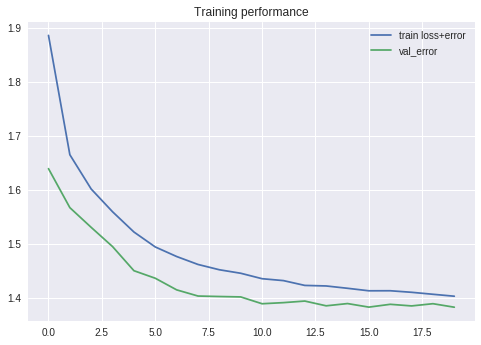

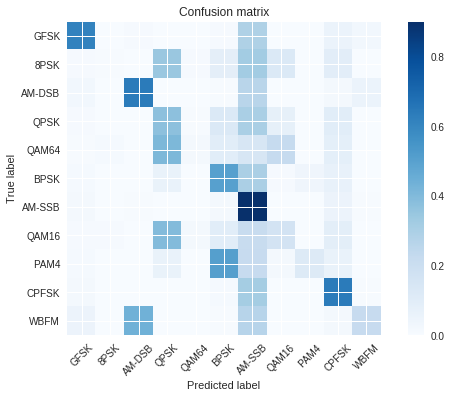

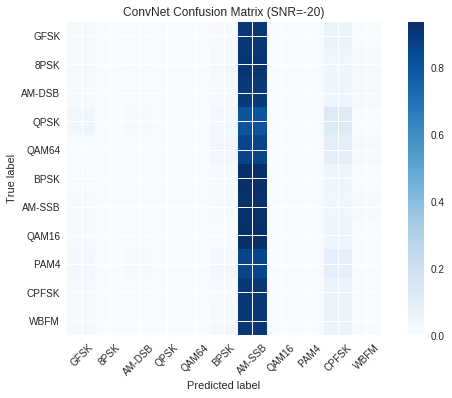

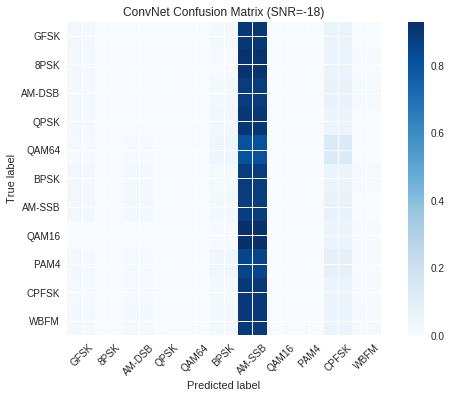

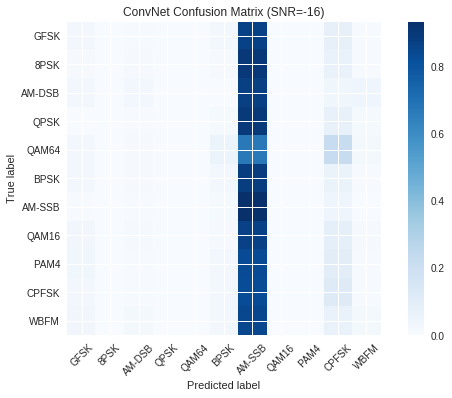

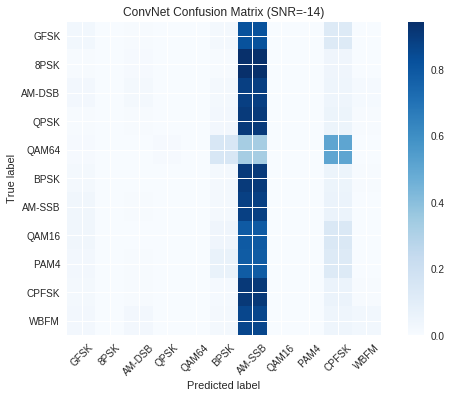

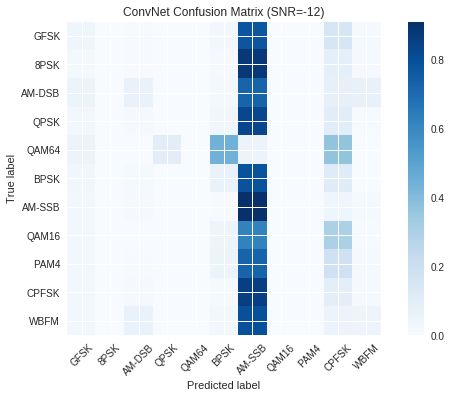

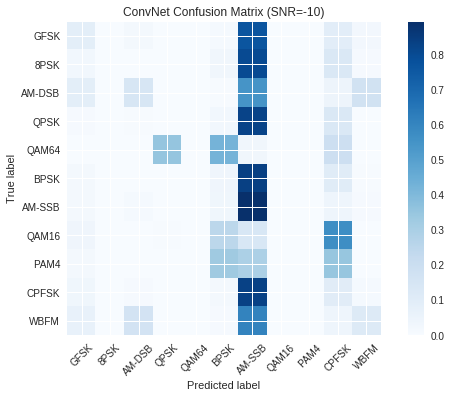

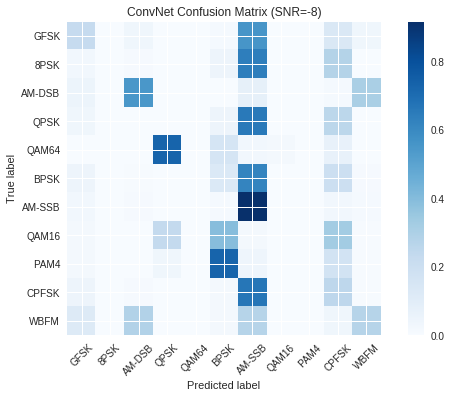

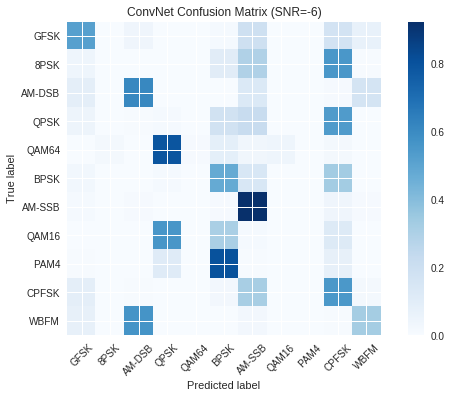

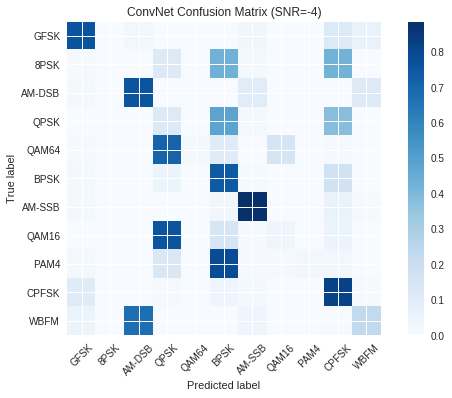

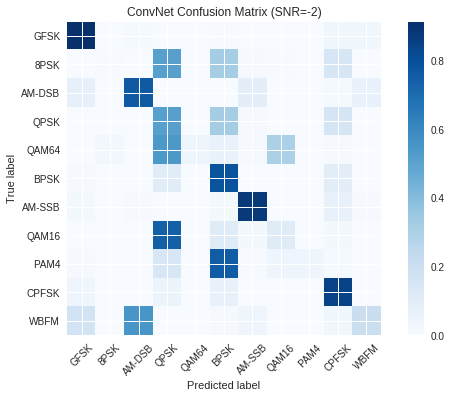

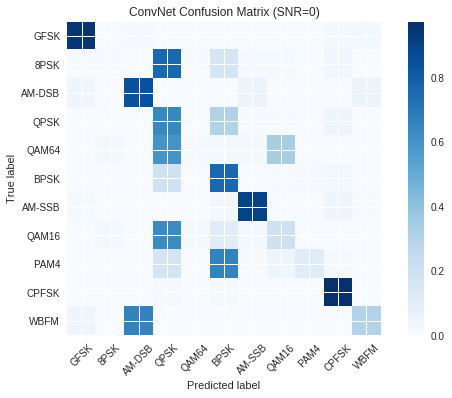

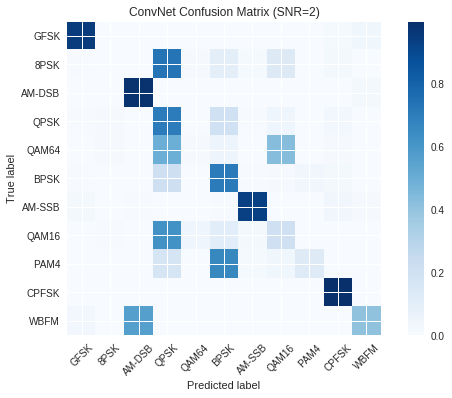

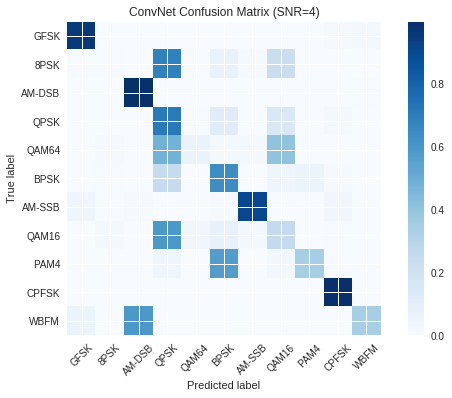

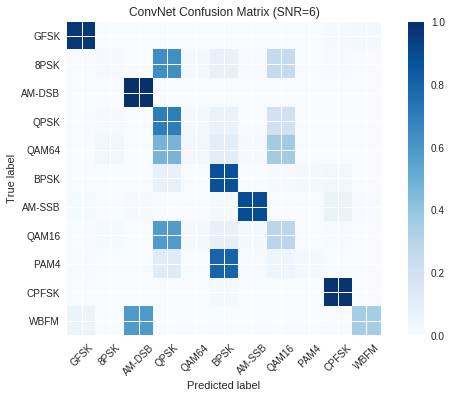

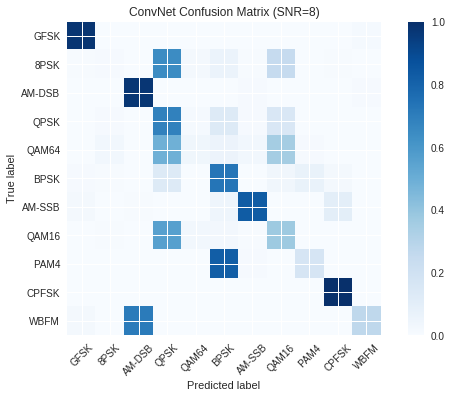

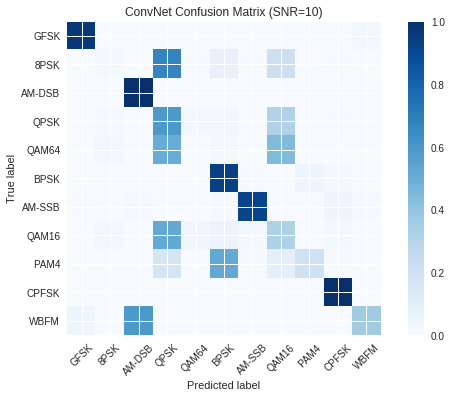

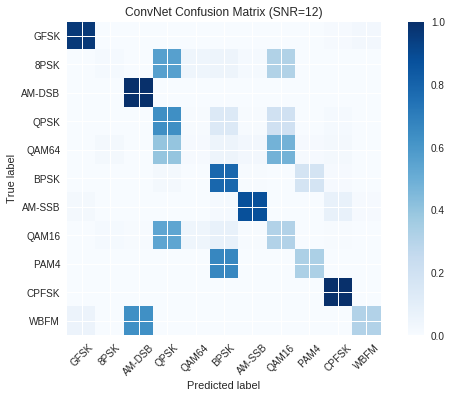

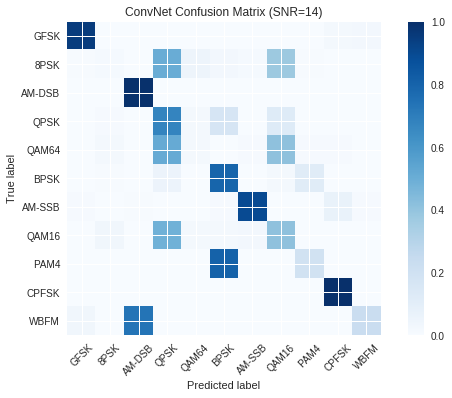

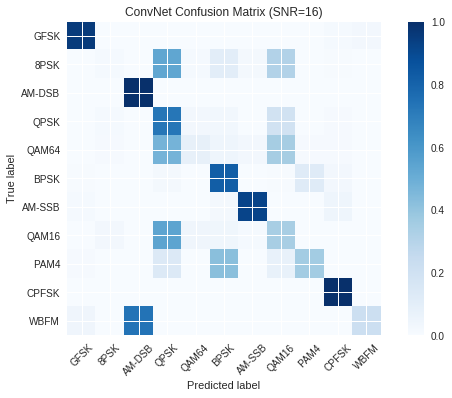

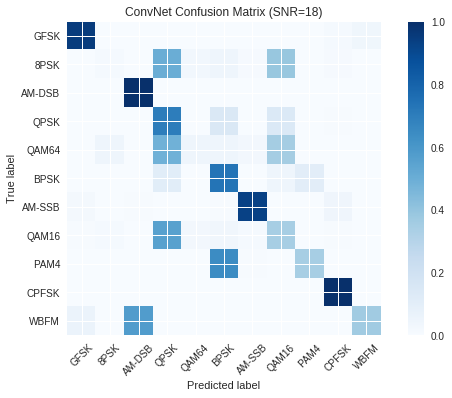

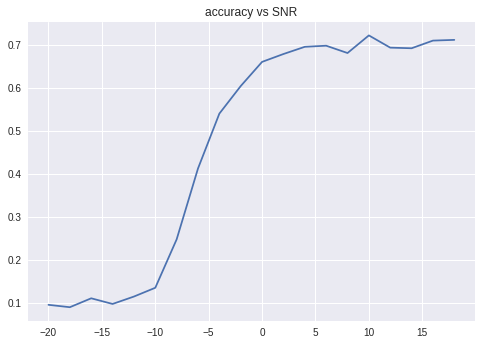

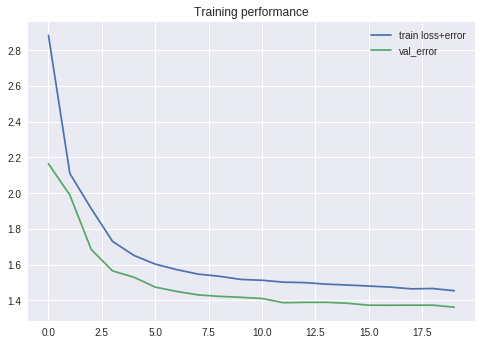

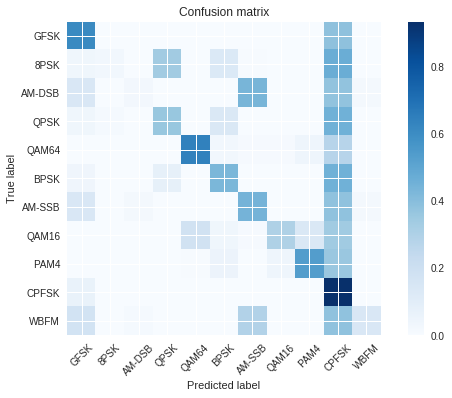

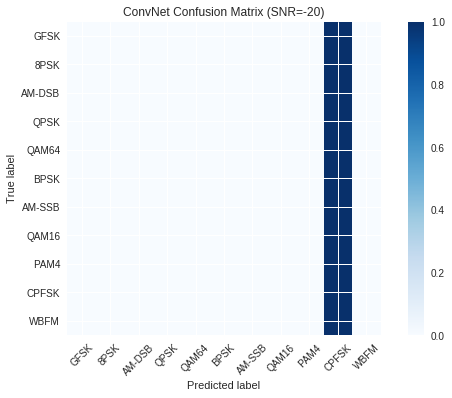

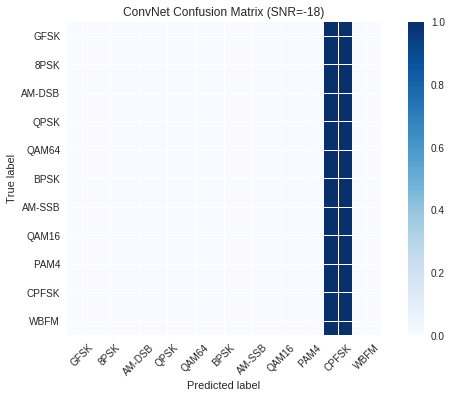

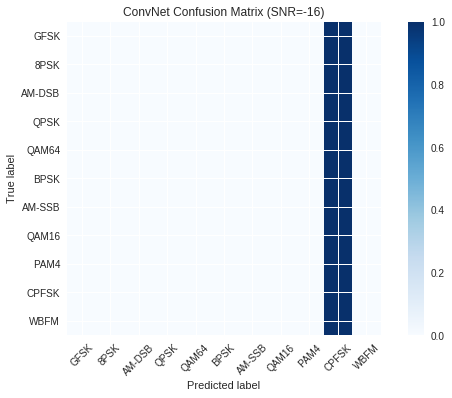

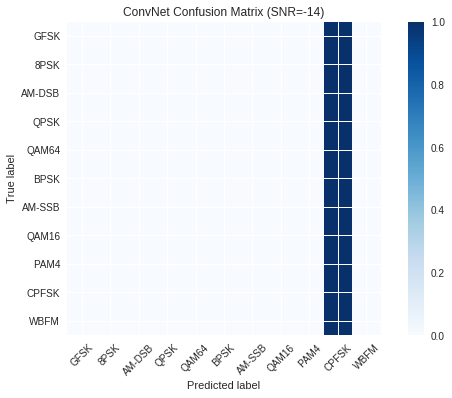

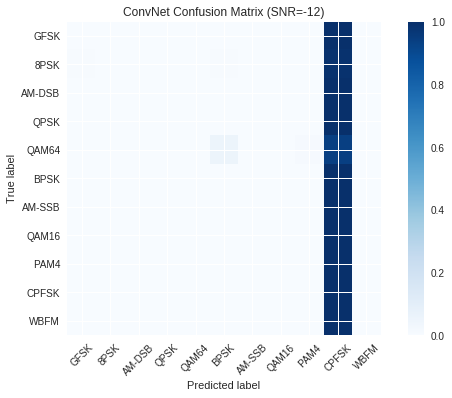

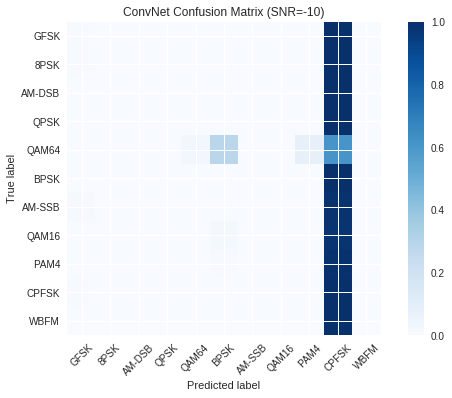

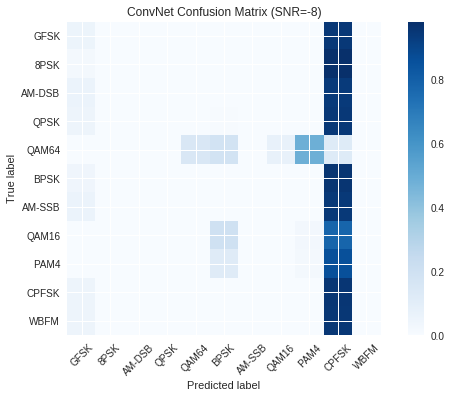

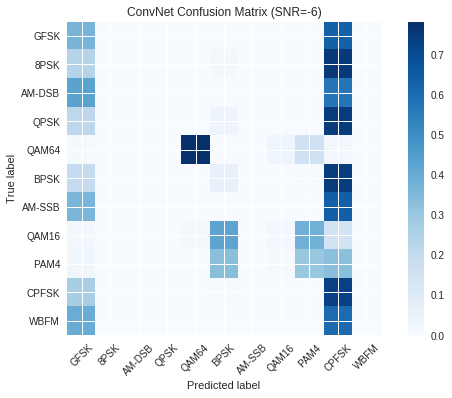

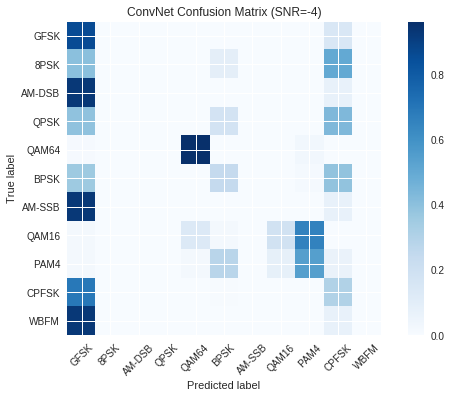

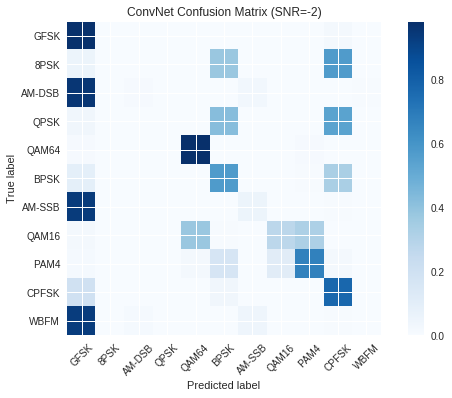

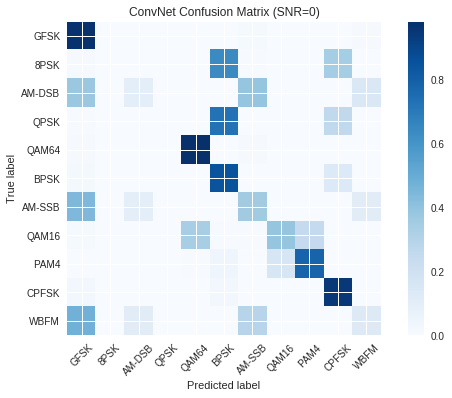

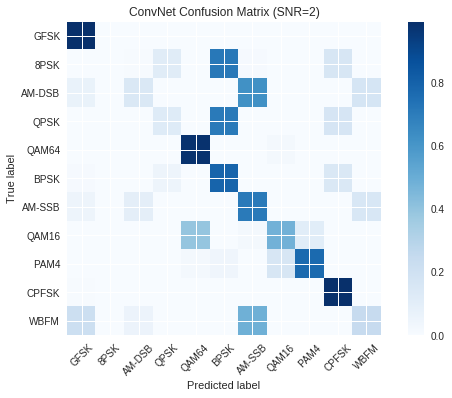

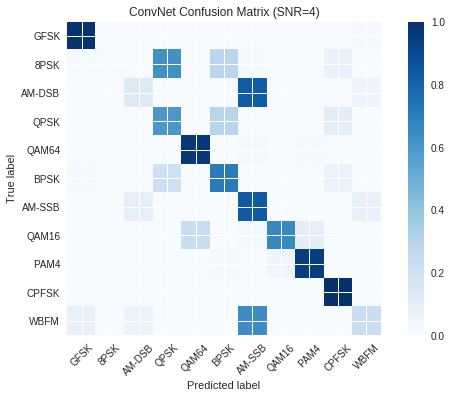

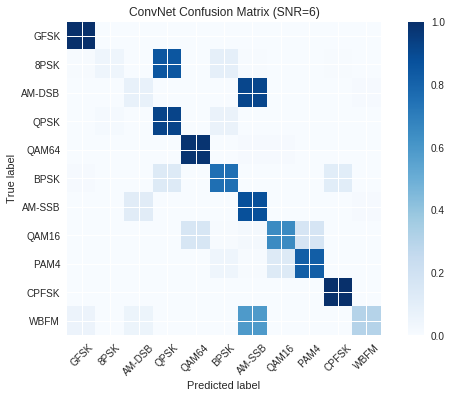

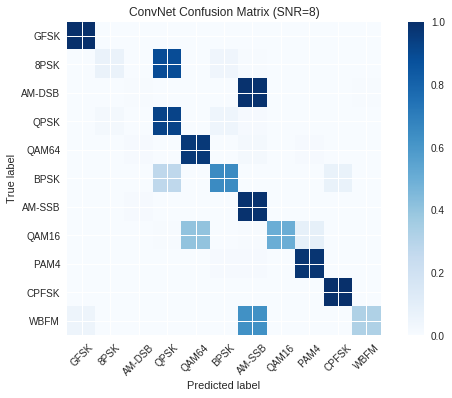

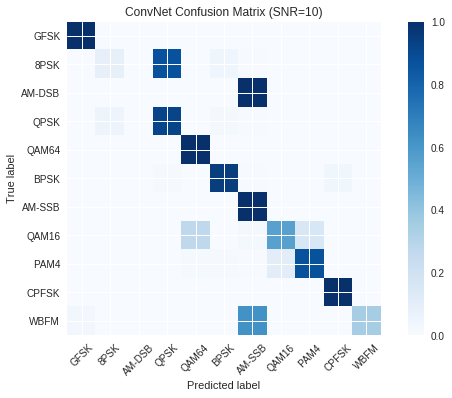

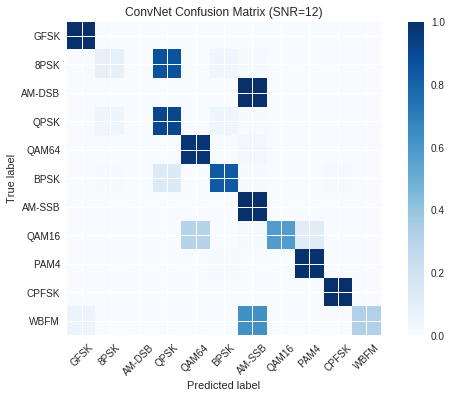

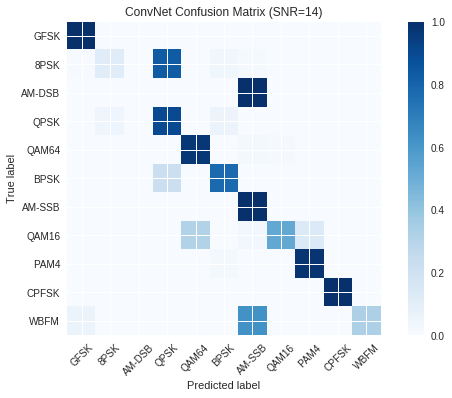

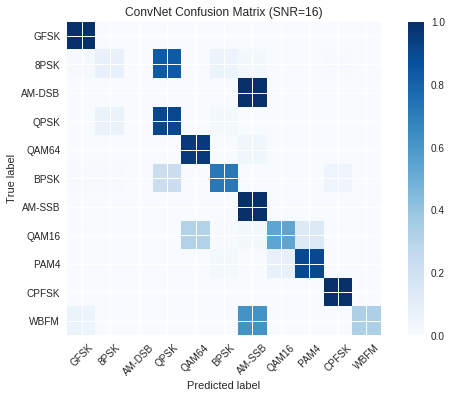

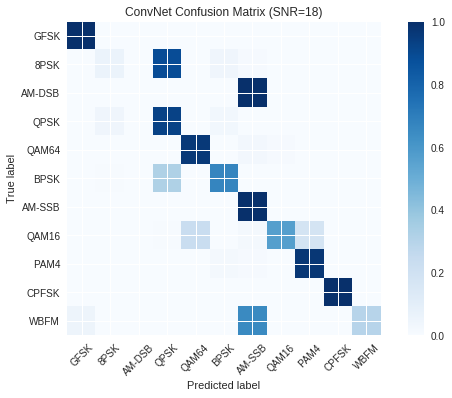

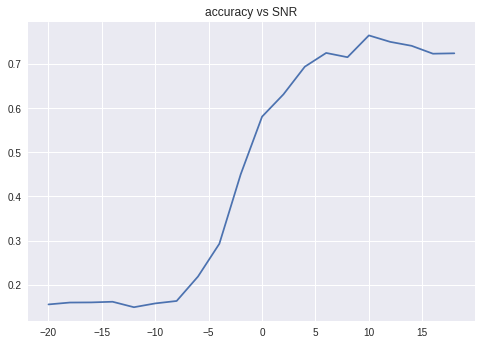

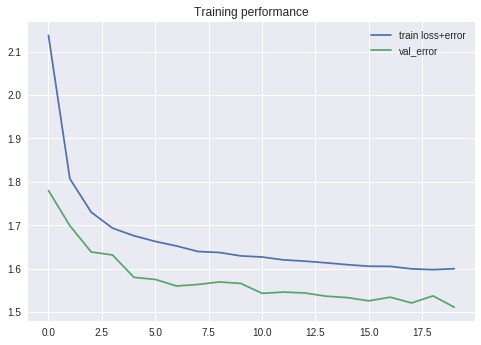

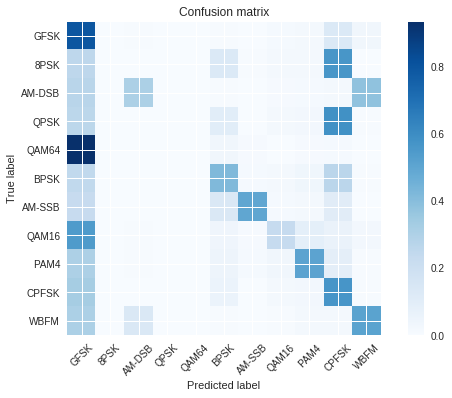

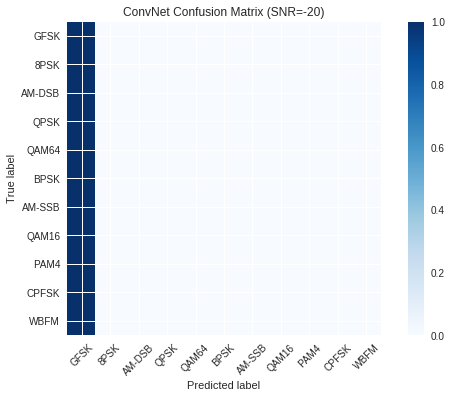

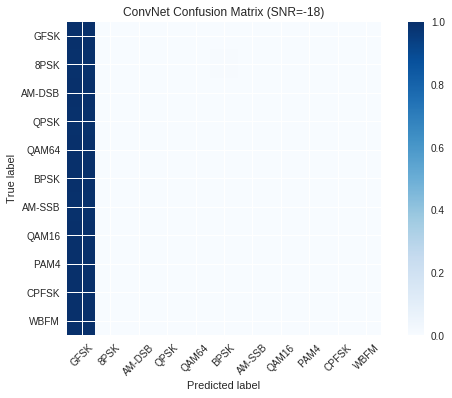

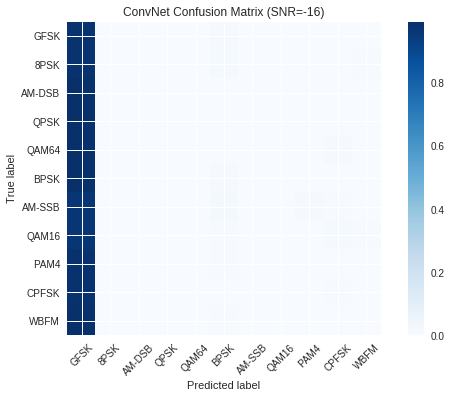

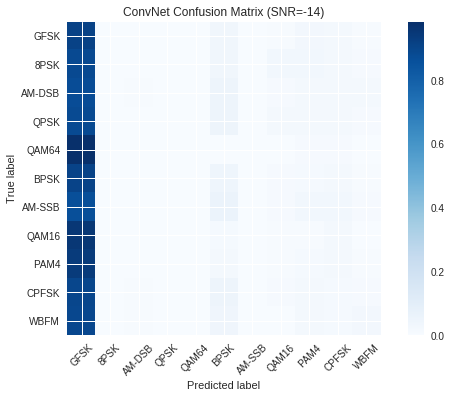

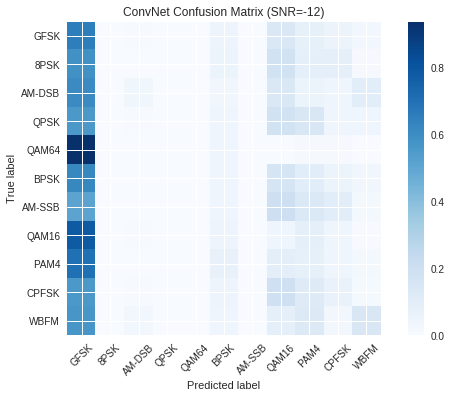

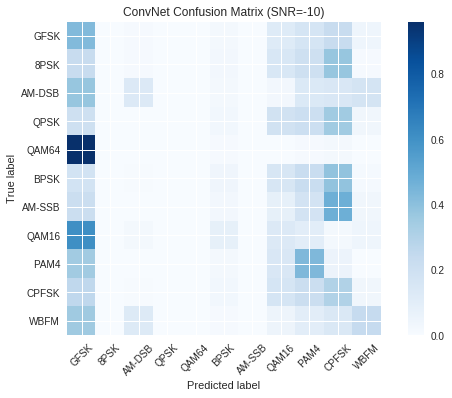

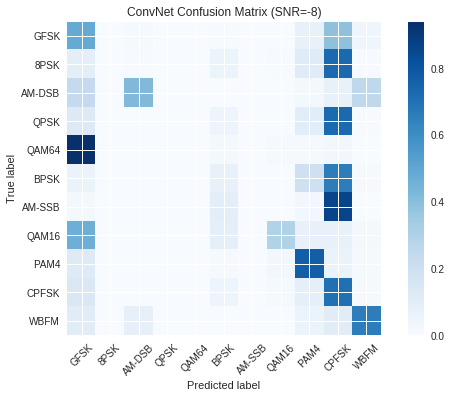

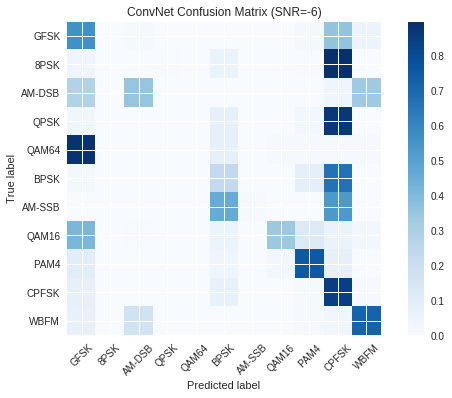

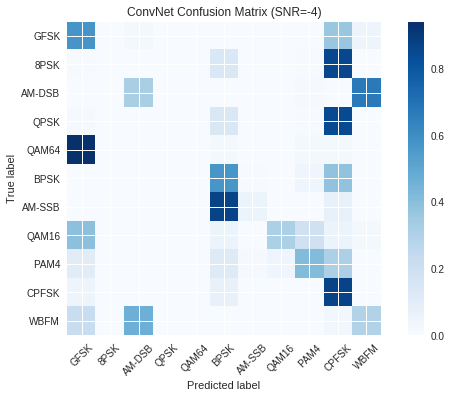

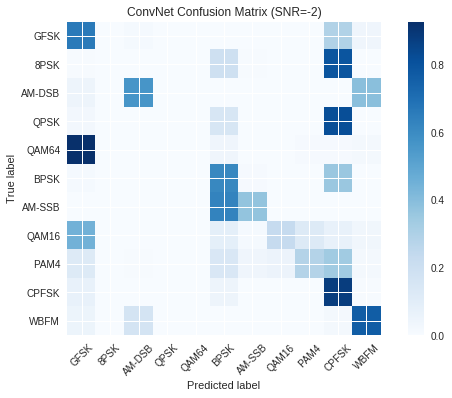

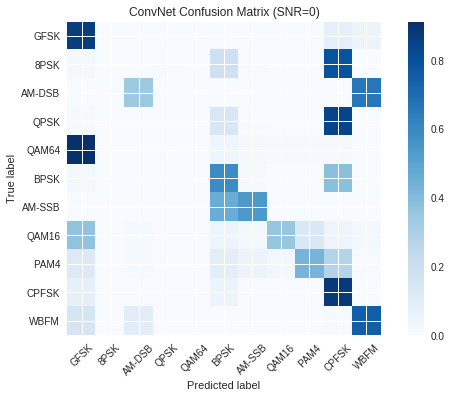

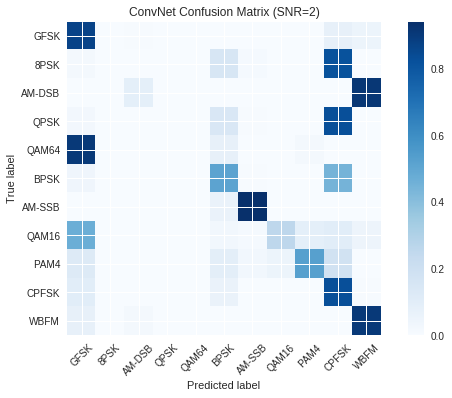

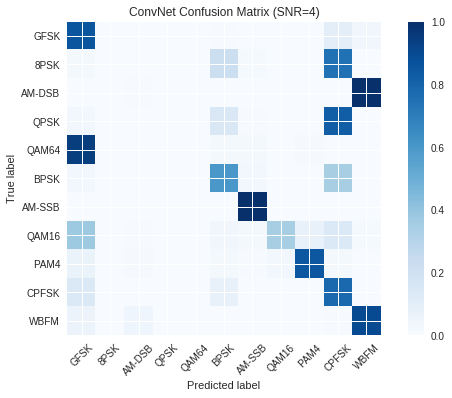

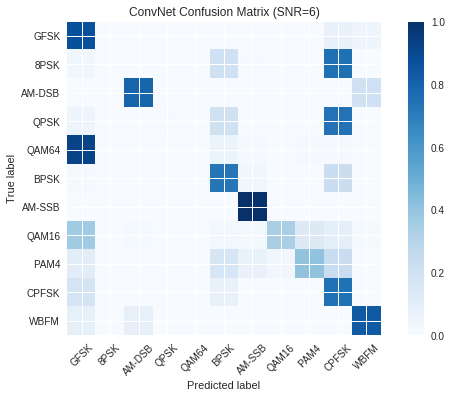

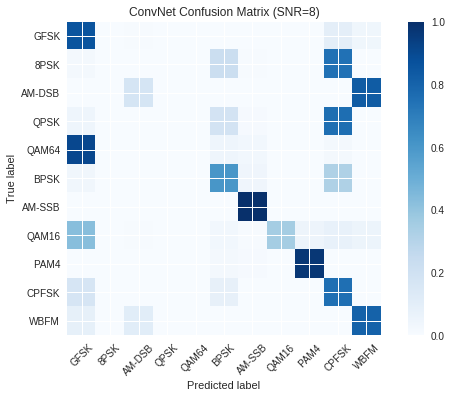

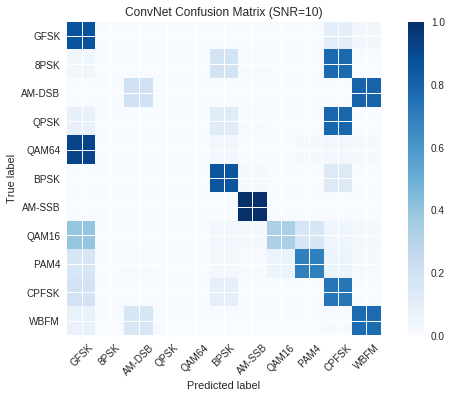

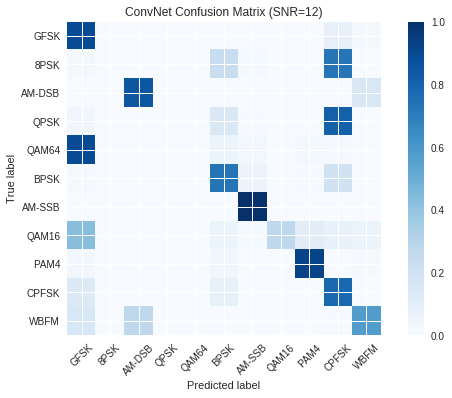

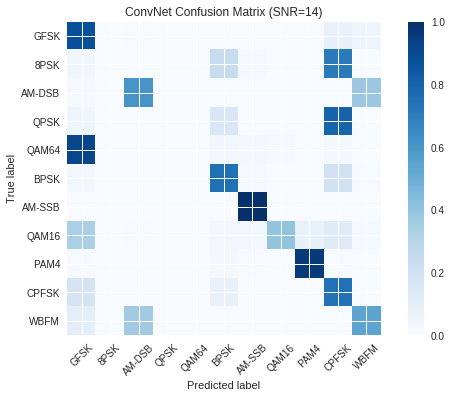

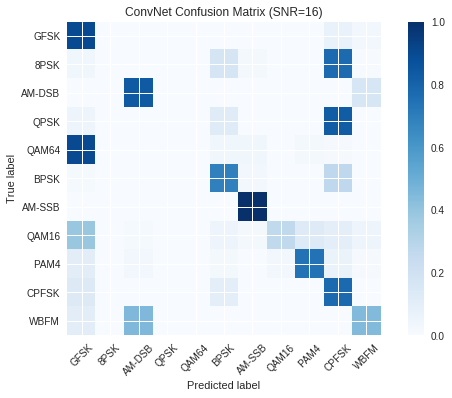

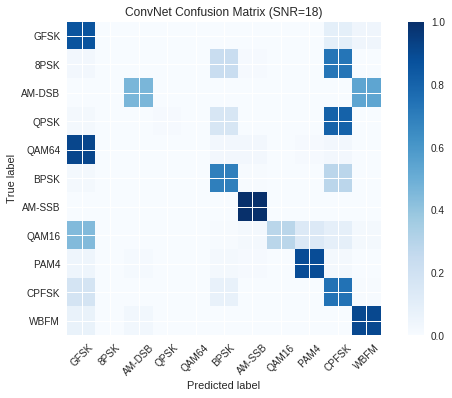

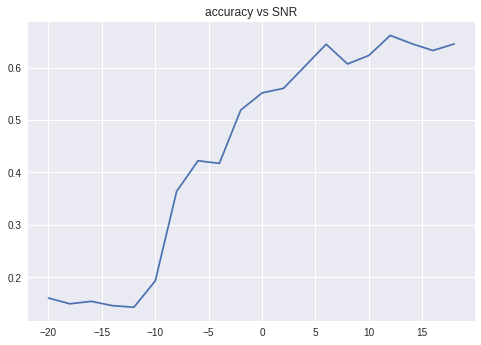

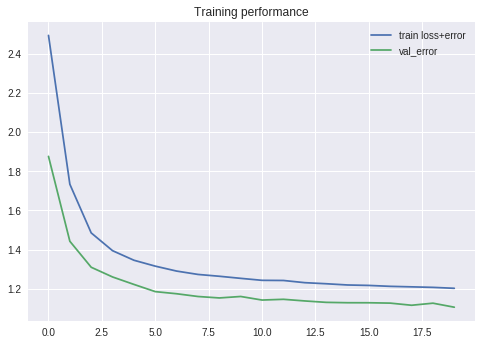

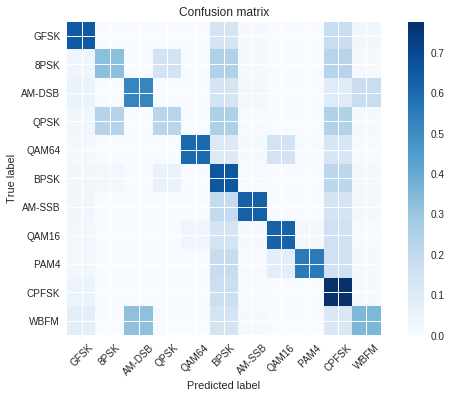

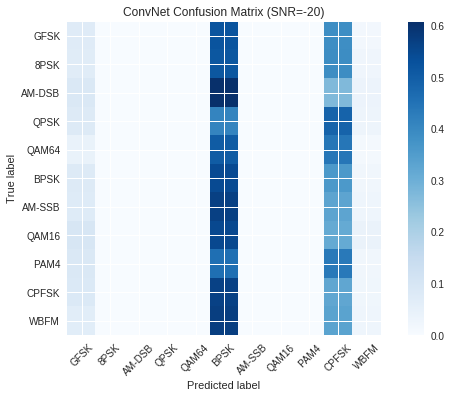

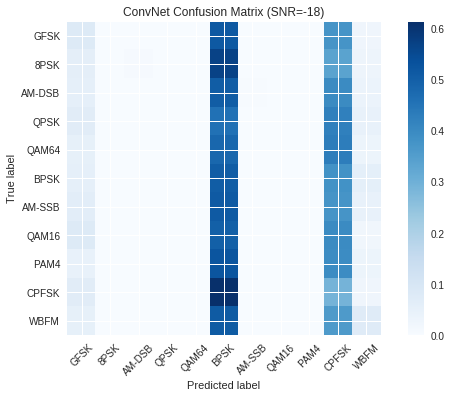

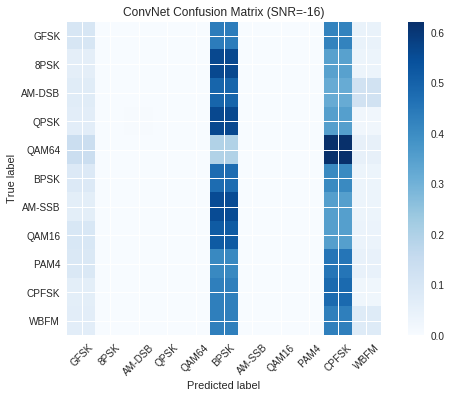

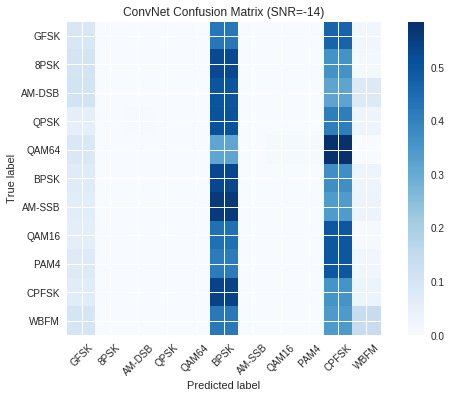

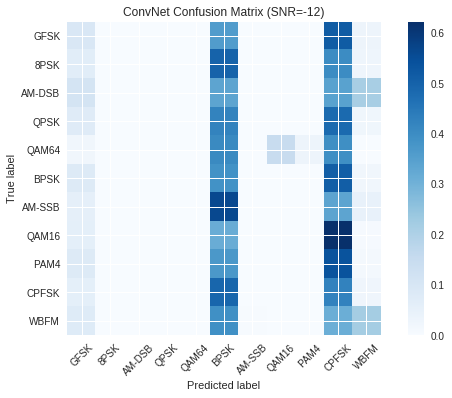

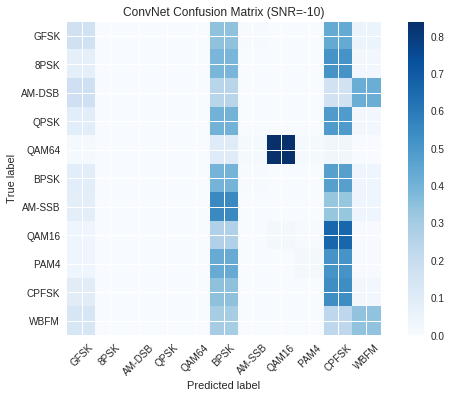

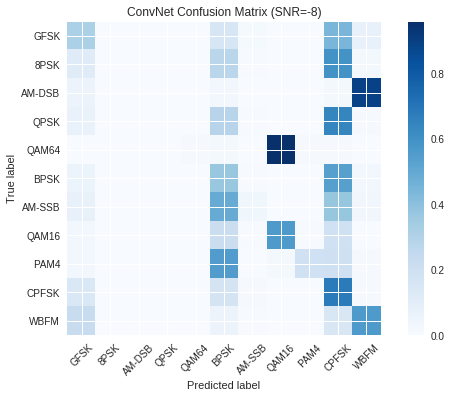

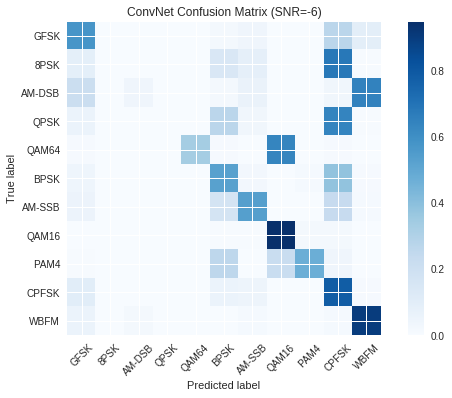

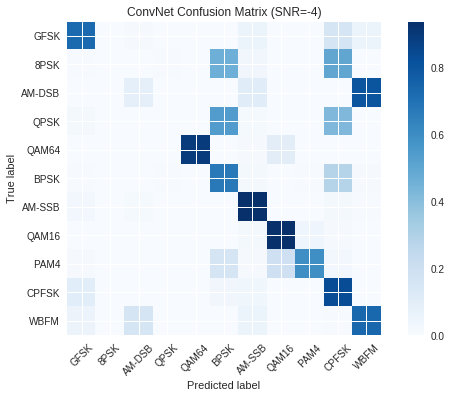

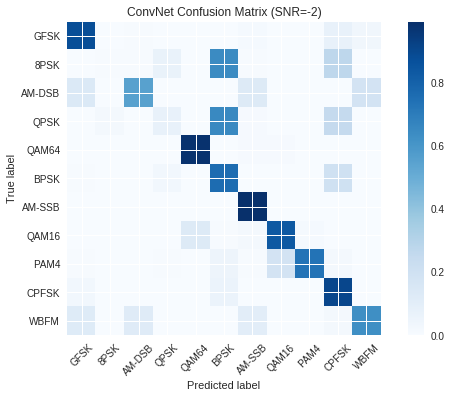

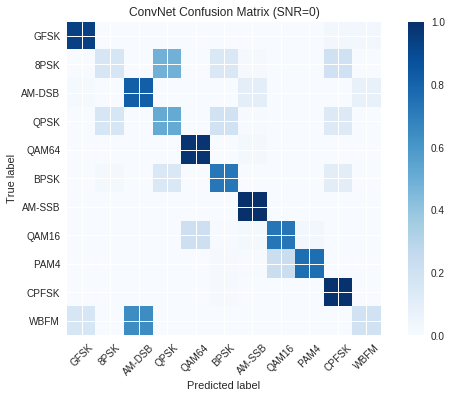

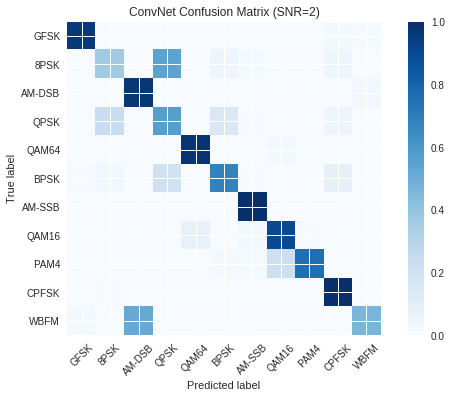

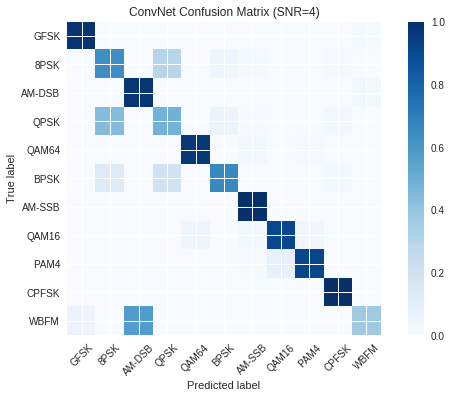

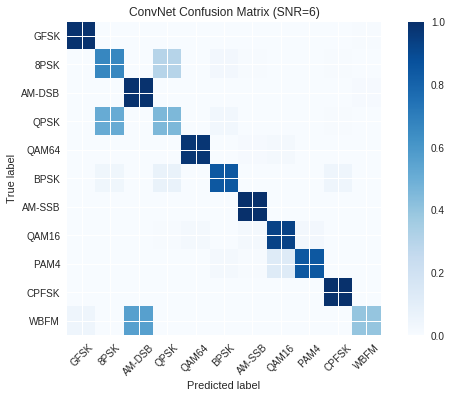

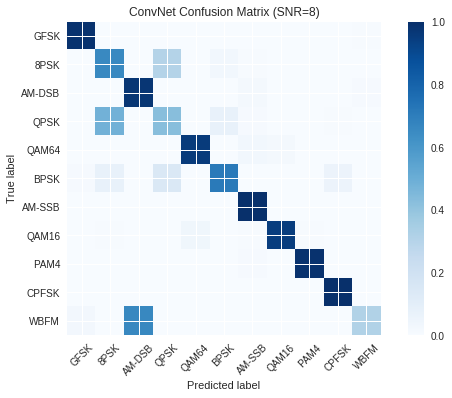

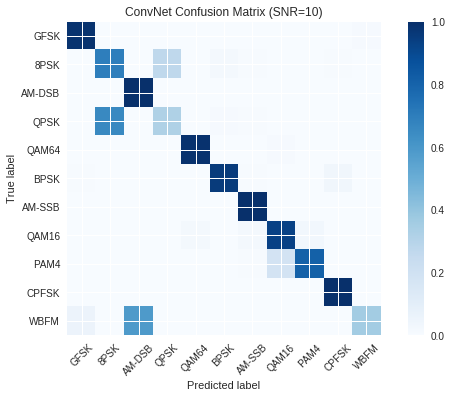

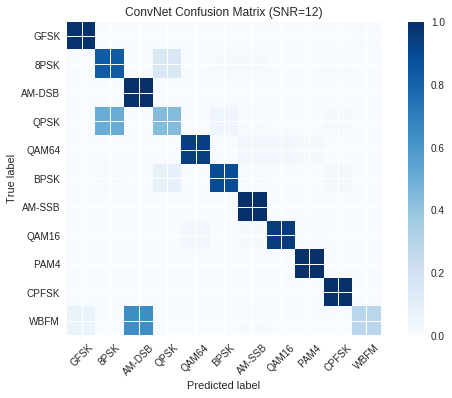

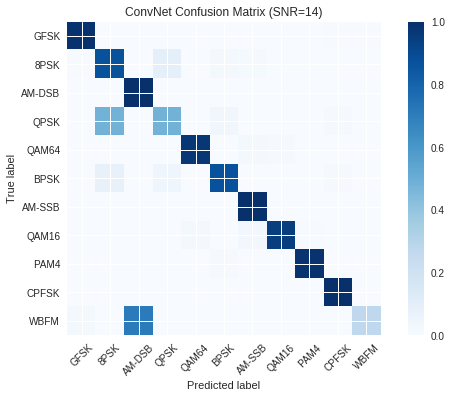

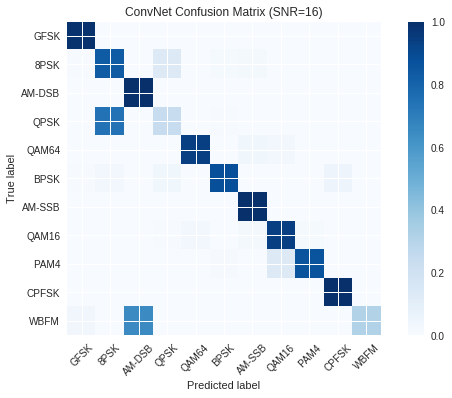

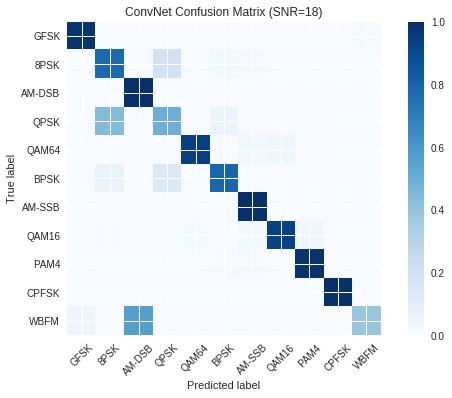

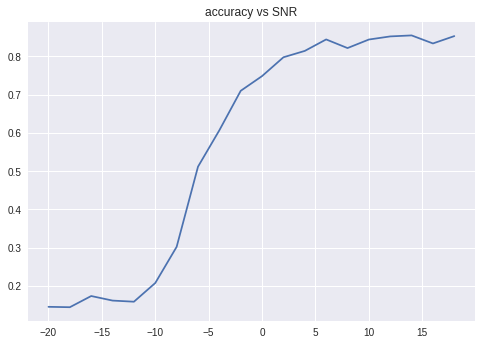

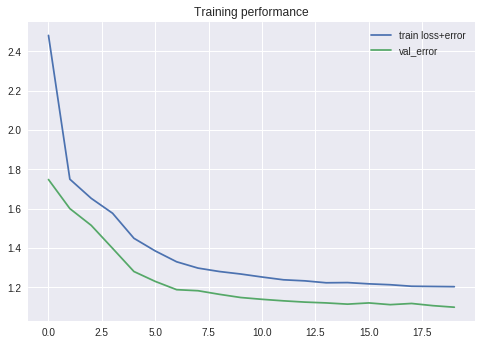

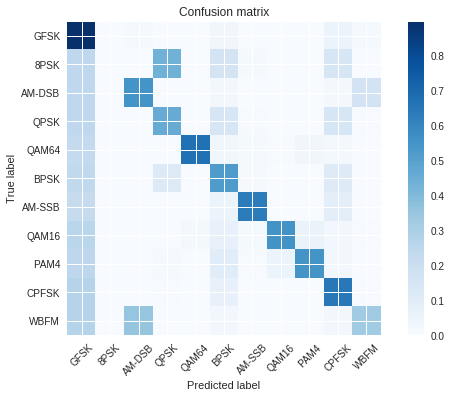

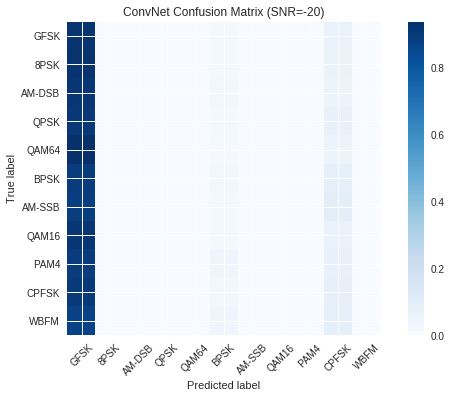

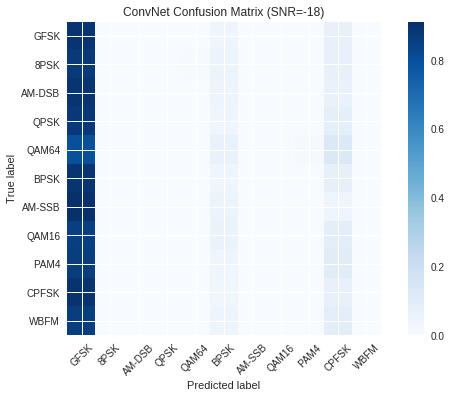

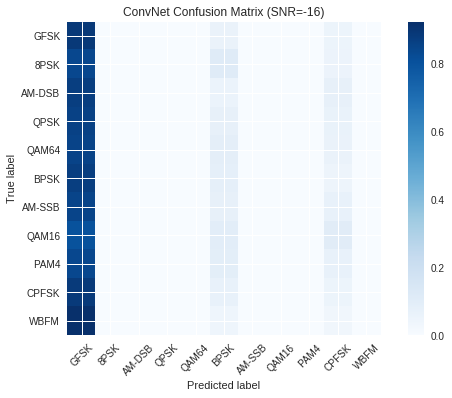

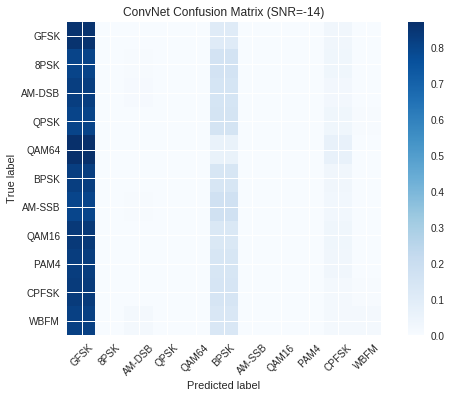

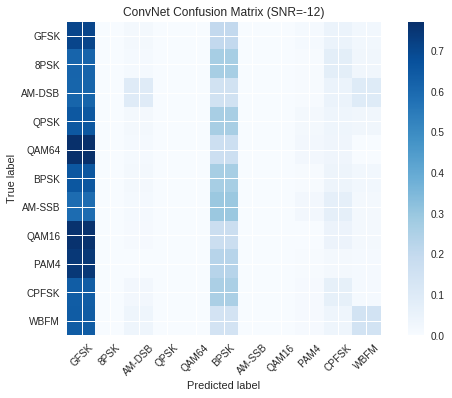

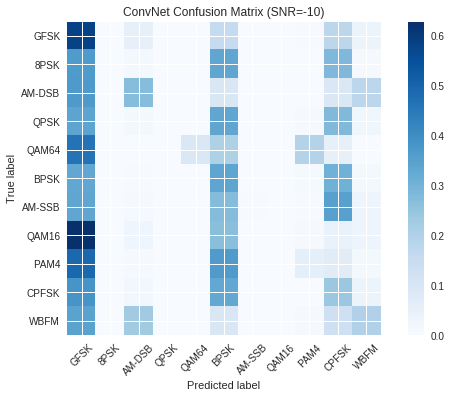

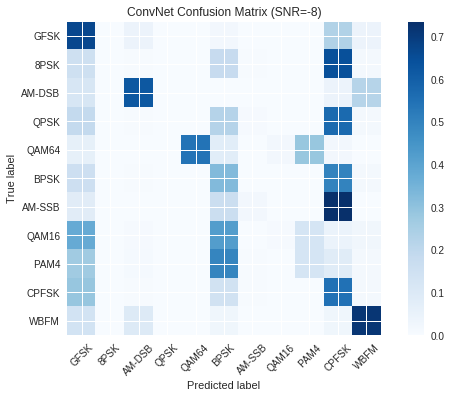

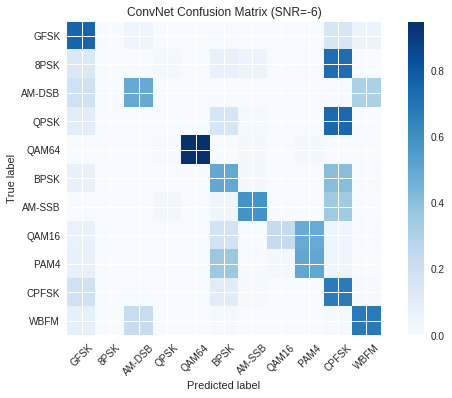

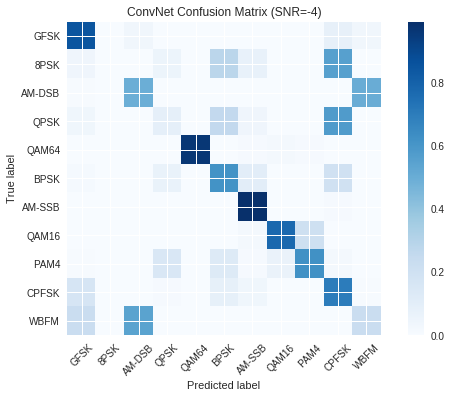

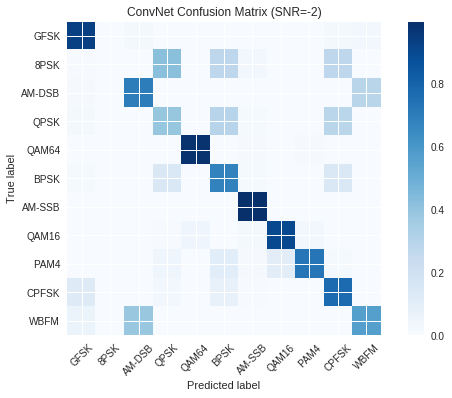

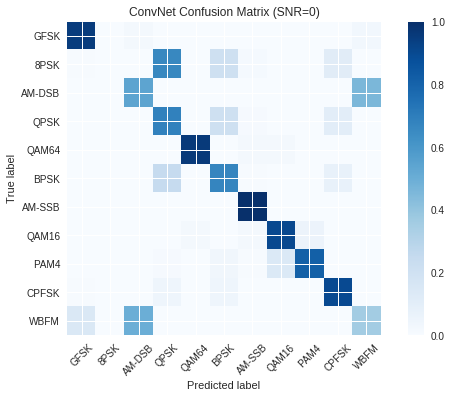

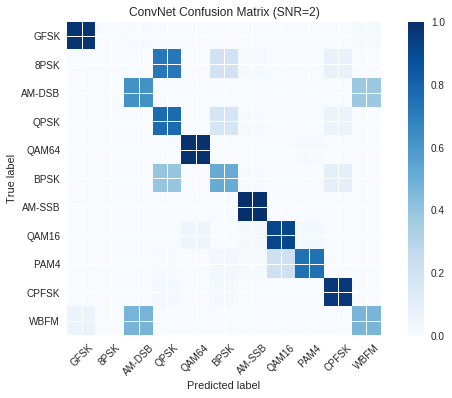

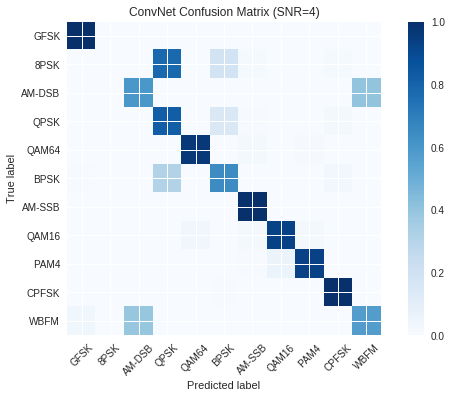

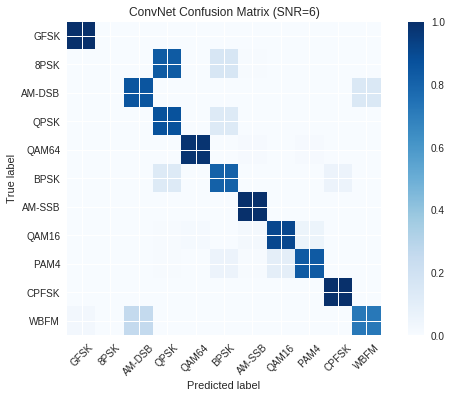

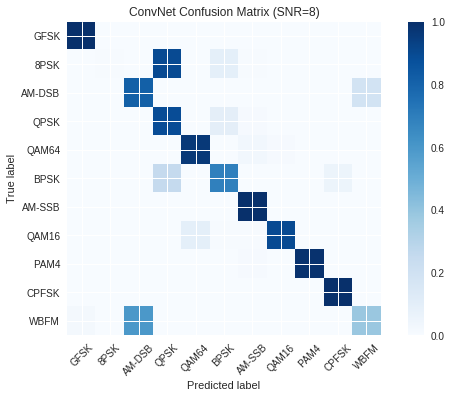

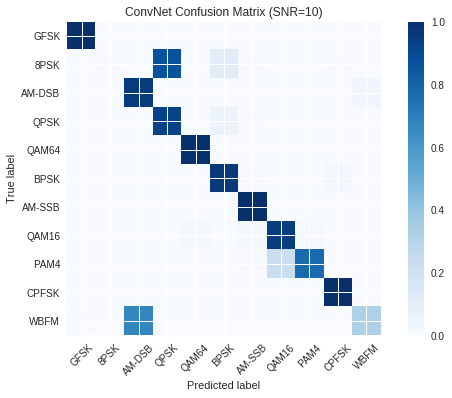

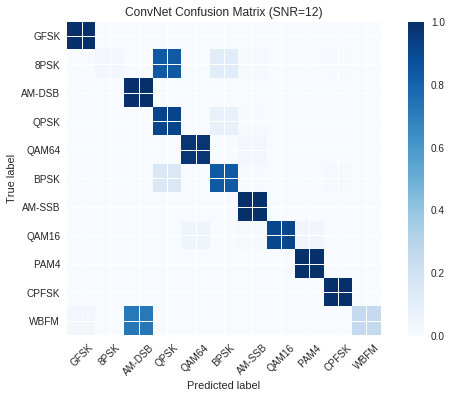

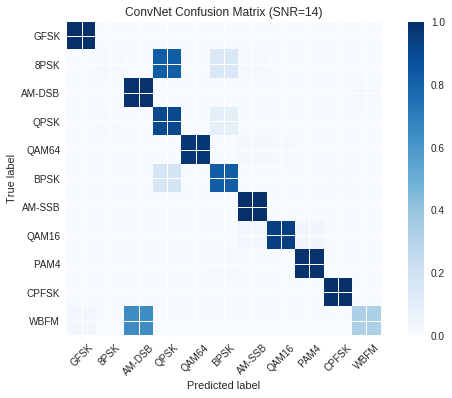

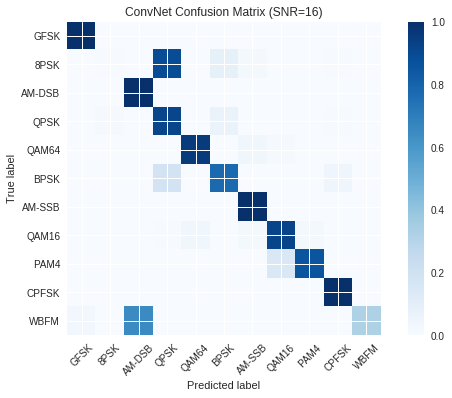

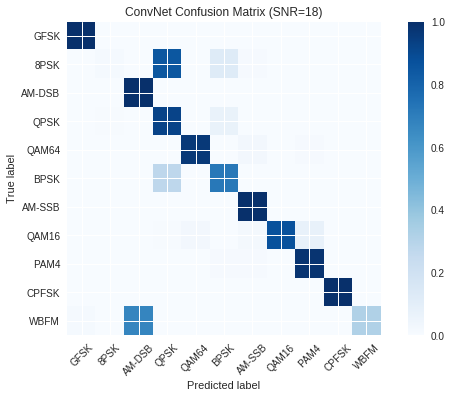

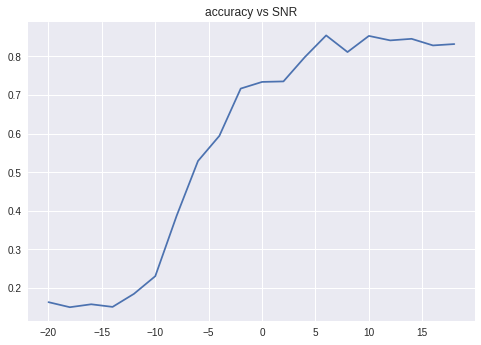

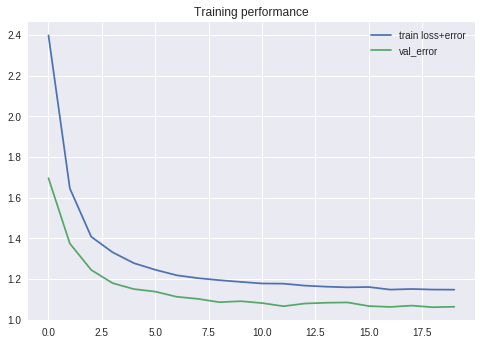

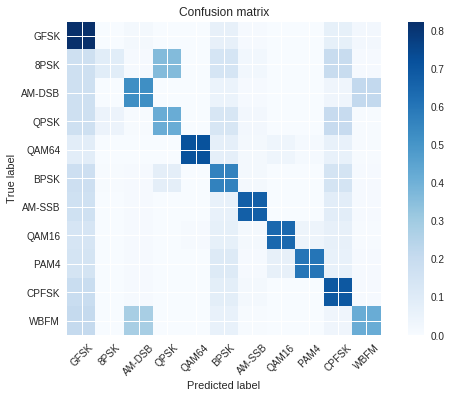

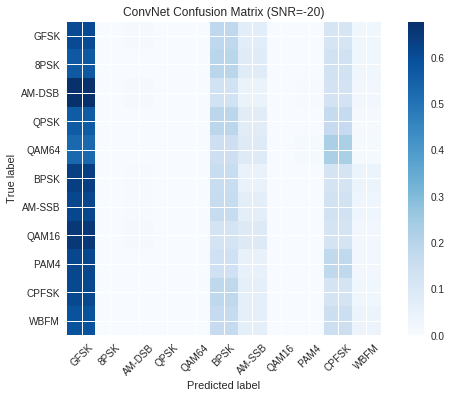

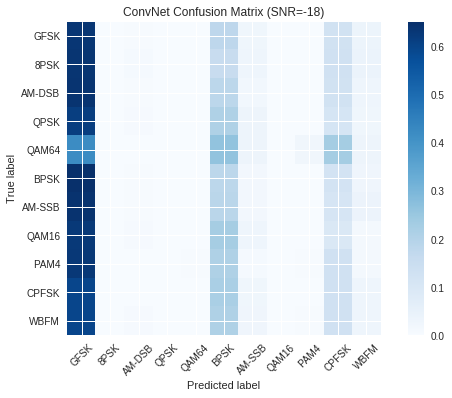

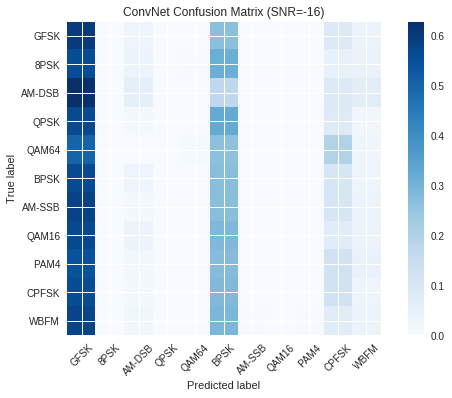

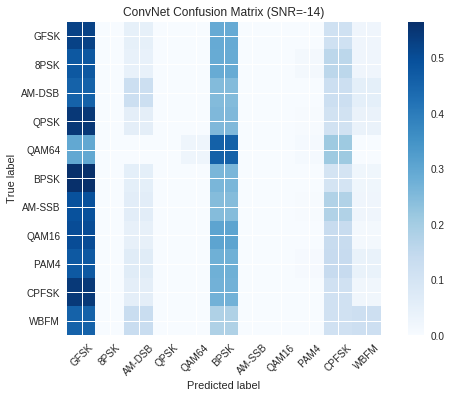

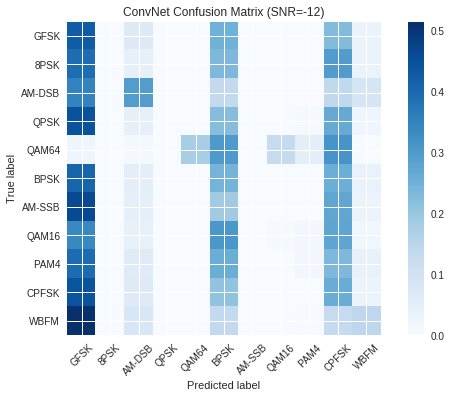

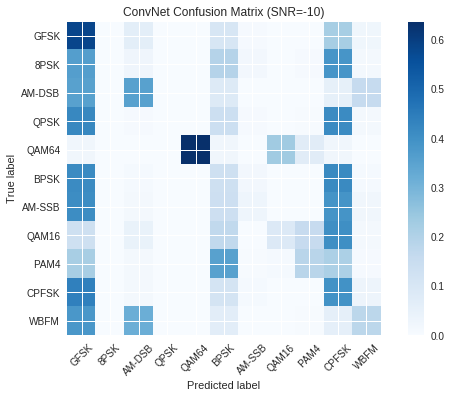

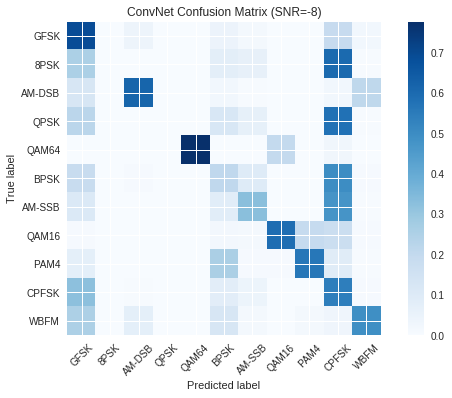

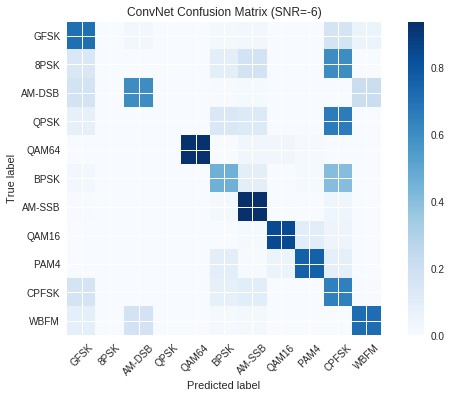

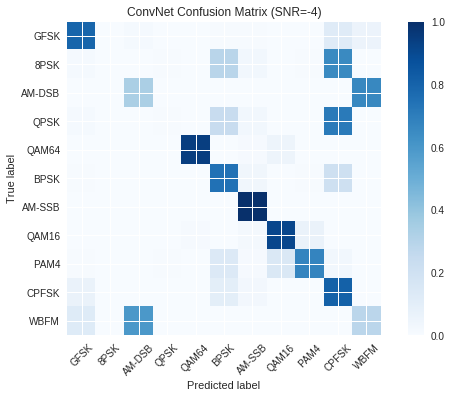

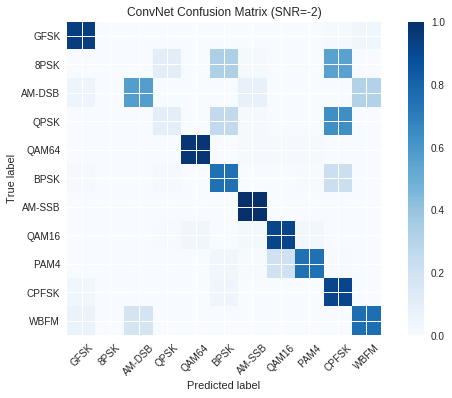

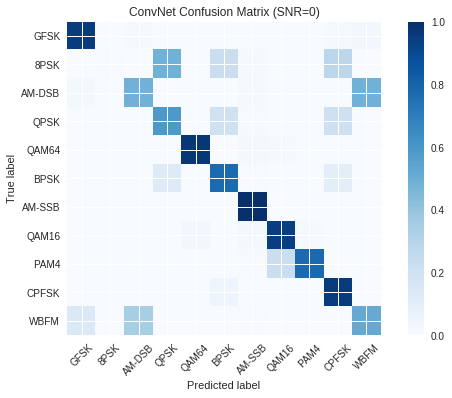

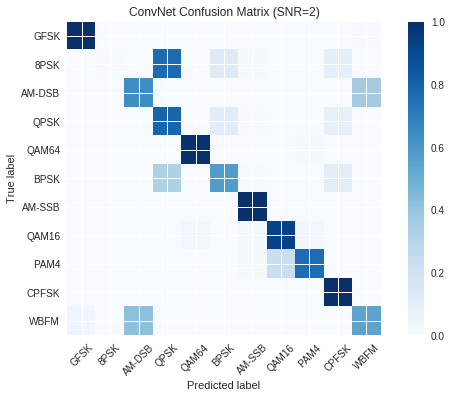

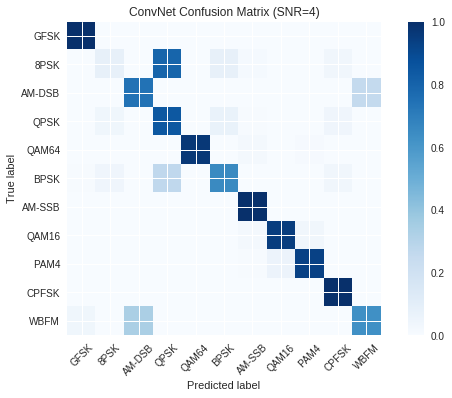

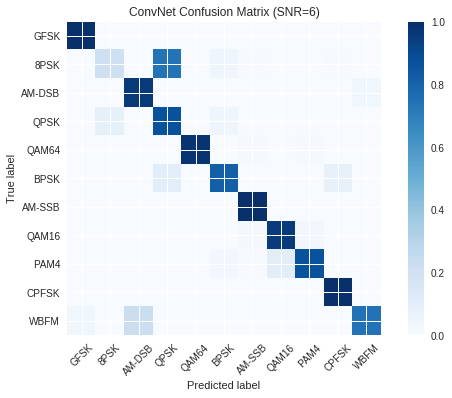

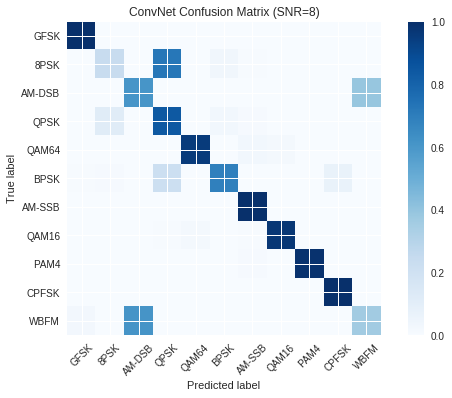

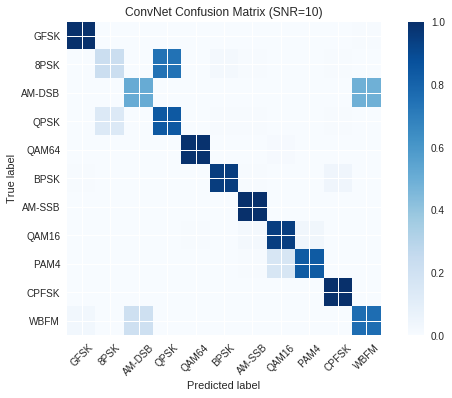

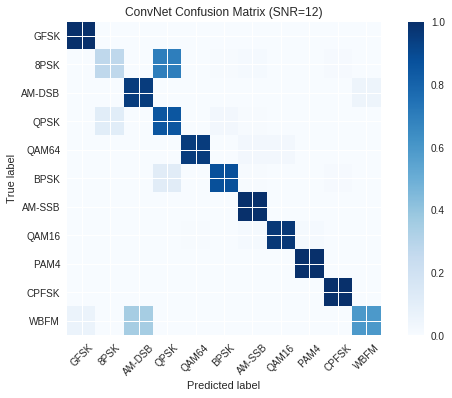

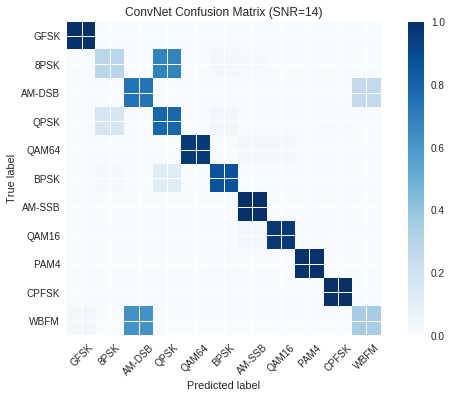

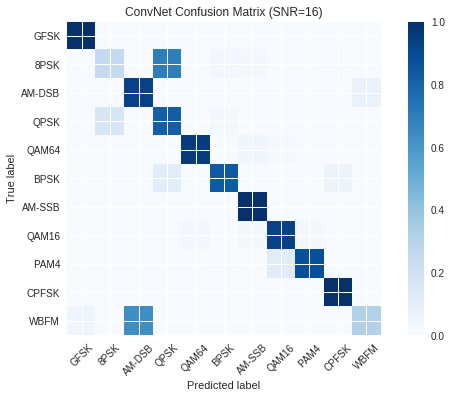

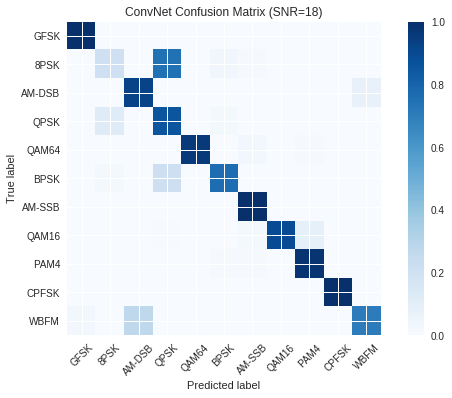

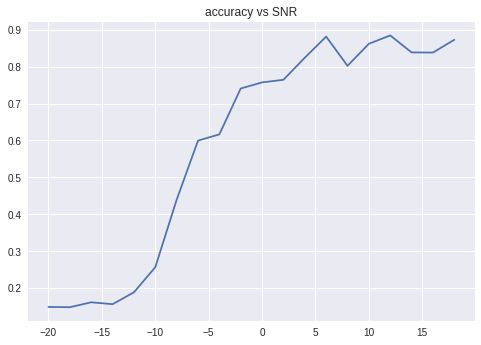

In [33]:
histoy_of_models=[]
for idx, model in enumerate(models):
  x_train = X_train[:,params[idx][0]:params[idx][1],:].copy()
  x_test = X_test[:,params[idx][0]:params[idx][1],:].copy()
  history = model.fit(x_train, y_train, epochs=20, validation_split=0.05)
  histoy_of_models.append(history)
  scores = model.evaluate(x_test, y_test)
  print(scores)
  
  plt.figure()
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='train loss+error')
  plt.plot(history.epoch, history.history['val_loss'], label='val_error')
  plt.legend()
  
  
  # Plot confusion matrix
  batch_size = 1024
  test_y_hat = model.predict(x_test, batch_size=batch_size)
  conf = np.zeros([len(modulations),len(modulations)])
  confnorm = np.zeros([len(modulations),len(modulations)])
  for i in range(0,x_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
  for i in range(0,len(modulations)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  plt.figure()
  plot_confusion_matrix(confnorm, labels=modulations)
  
  acc = {}
  for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: int(x[1]), lbl_test))
    test_X_i = x_test[np.where(np.array(test_SNRs)==snr)]
    test_y_i = y_test[np.where(np.array(test_SNRs)==snr)]

    # estimate classes
    test_y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(modulations),len(modulations)])
    confnorm = np.zeros([len(modulations),len(modulations)])
    for i in range(0,test_X_i.shape[0]):
      j = list(test_y_i[i,:]).index(1)
      k = int(np.argmax(test_y_i_hat[i,:]))
      conf[j,k] = conf[j,k] + 1
    for i in range(0,len(modulations)):
      confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=modulations, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
  
  plt.figure()
  plt.title('accuracy vs SNR')
  plt.plot(snrs, [acc[snr] for snr in snrs], label='accuracy')

In [ ]:
for  model in models:
  acc = {}
  reqired_snrs=[-4,0,10] 
  for snr in reqired_snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: int(x[1]), lbl_test))
    test_X_i = x_test[np.where(np.array(test_SNRs)==snr)]
    test_y_i = y_test[np.where(np.array(test_SNRs)==snr)]

    # estimate classes
    test_y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(modulations),len(modulations)])
    confnorm = np.zeros([len(modulations),len(modulations)])
    for i in range(0,test_X_i.shape[0]):
      j = list(test_y_i[i,:]).index(1)
      k = int(np.argmax(test_y_i_hat[i,:]))
      conf[j,k] = conf[j,k] + 1
    for i in range(0,len(modulations)):
      confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=modulations, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
  
  plt.figure()
  plt.title('accuracy vs SNR')
  plt.plot(snrs, [acc[snr] for snr in snrs], label='accuracy')

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for idx,model in enumerate(models):
  # serialize model to JSON
  model_json = model.to_json()
  with open("combFNN"+str(idx)+".json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("combFNN"+str(idx)+".h5")
  print("Saved model to disk")
  files = []
  files.append("combFNN"+str(idx)+".json", "w")
  files.append("combFNN"+str(idx)+".h5")
  upload_files(drive, folder_id, files)


In [ ]:
loaded_models = []
# upload the the six created models
for idx in range(6):
  json_file = open('/content/data/combFNN'+str(idx)+'.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)

  # load weights into new model
  loaded_model.load_weights('/content/data/combFNN'+str(idx)+'.h5')
  print("Loaded model from disk")

  # evaluate loaded model on test data
  loaded_model.compile ( loss='categorical_crossentropy' , optimizer='adam' , metrics = ['accuracy'] )
  loaded_models.append(loaded_model)